# 학습한 모델의 오브젝트 탐지 확인

### 모델 로드

In [1]:
from ultralytics import YOLO

model = YOLO("yolov8n_merged_1920.pt")

### 이미지 오브젝트 탐지

In [2]:
from PIL import Image
import cv2

# 바운딩 박스 시각화 함수
def draw_result(result, color_map={0: (255, 0, 0), 80: (0, 255, 0)}, thickness=1):
  img = result.orig_img[:, :, ::-1].copy()
  box_coordinate = result.boxes.xyxy.int().tolist()
  box_cls = result.boxes.cls.int().tolist()

  for coordinate, cls in zip(box_coordinate, box_cls):
    x1, y1, x2, y2 = coordinate
    color = color_map[cls]
    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
  return Image.fromarray(img)

In [3]:
results = model.predict(
    source="/content/datasets/test5.jpg", # source image from https://clintongreenway.org/
    classes=[0, 80],
    imgsz=1920,
    conf=0.25,
    save=False,
)


image 1/1 /content/datasets/test5.jpg: 1344x1920 17 0s, 14 80s, 91.6ms
Speed: 13.9ms preprocess, 91.6ms inference, 117.7ms postprocess per image at shape (1, 3, 1344, 1920)


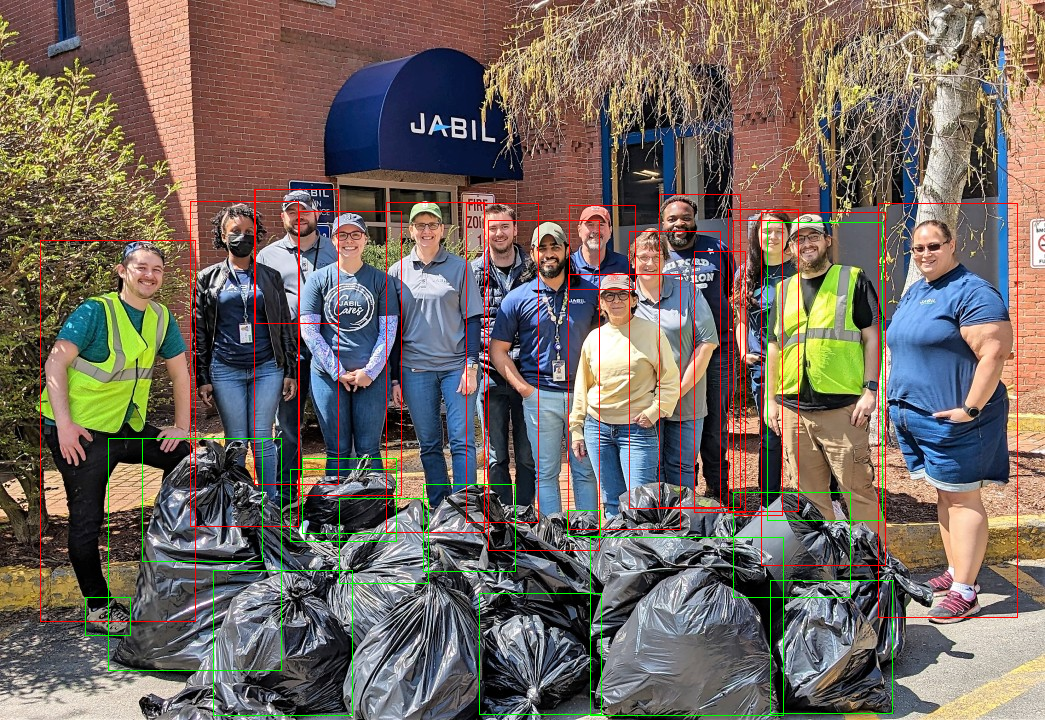

In [4]:
draw_result(results[0])

### 영상 오브젝트 탐지

In [5]:
results = model.predict(
    source='/content/datasets/test1.mp4',
    imgsz=1920,
    classes=[0, 80],
    conf=0.25,
    save=False,
)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/361) /content/datasets/test1.mp4: 1088x1920 (no detections), 115.5ms
video 1/1 (frame 2/361) /content/datasets/test1.mp4: 1088x1920 (no detections), 5.5ms
video 1/1 (frame 3/361) /content/datasets/test1.mp4: 1088x1920 (no detections), 5.4ms
video 1/1 (frame 4/361) /content/datasets/test1.mp4: 1088x1920 (no detections), 5.4ms
video 1/1 (frame 5/361) /content/datasets/test1.mp4: 1088x1920 (no detections), 5.4ms
video 1/1 (frame 6/361) 

#### 영상 오브젝트 탐지 통계 시각화

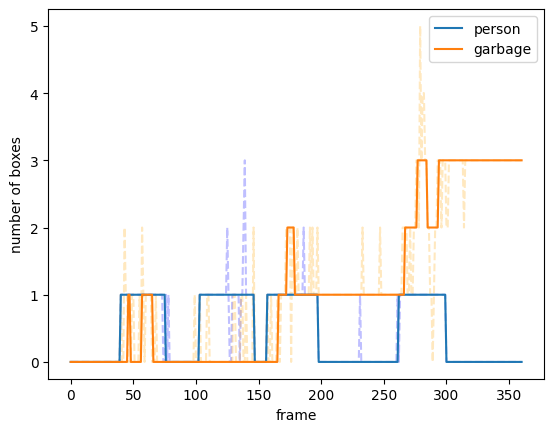

In [6]:
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

def draw_plot(results):
  x = [i for i in range(len(results))]
  y1 = [result.boxes.cls.int().tolist().count(0) for result in results]
  y2 = [result.boxes.cls.int().tolist().count(80) for result in results]
  plt.plot(x, y1, color="blue", linestyle='dashed', alpha=0.25)
  plt.plot(x, y2, color="orange", linestyle='dashed', alpha=0.25)

  y1 = median_filter(y1, size=9)
  y2 = median_filter(y2, size=9)

  plt.plot(x, y1, label="person")
  plt.plot(x, y2, label="garbage")
  plt.xlabel("frame")
  plt.ylabel("number of boxes")
  plt.legend()
  plt.savefig("result.png", dpi=500)
  plt.show()

draw_plot(results)

#### 탐지된 객체 움직임 시각화

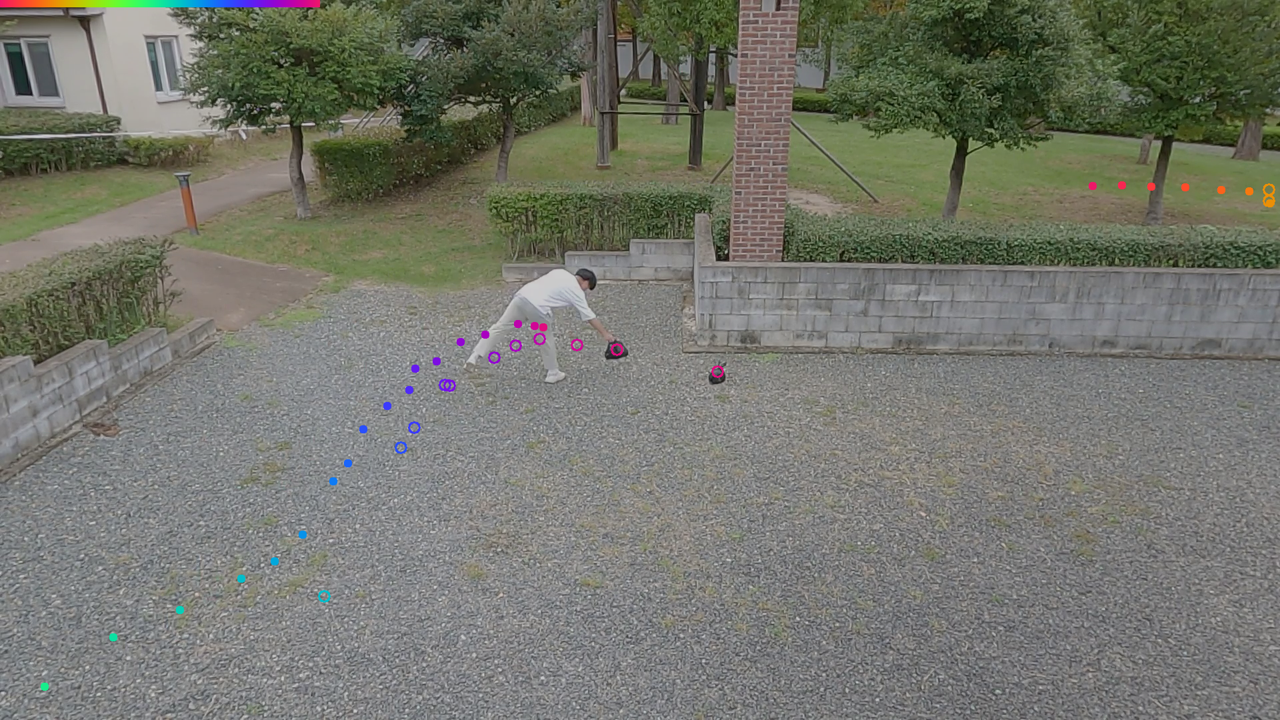

In [7]:
import cv2
import math

def rainbow(f, max_f):
    f = f / max_f * 2 * math.pi 
    f = -f + math.pi * (2/3)
    r = math.sin(f) * 127 + 128
    g = math.sin(f + 2) * 127 + 128
    b = math.sin(f + 4) * 127 + 128
    return (int(r), int(g), int(b))

def draw_history(results):
    img = results[-1].orig_img[:, :, ::-1].copy()
    max_f = len(results)
    
    img = cv2.addWeighted(img, 0.8, img, 0, 0)

    for f, result in enumerate(results):
        boxes = result.boxes
        for box in boxes:
            if box.cls == 0:
                x, y, w, h = box.xywh.int().tolist()[0]
                cv2.rectangle(img, (x, y), (x+5, y+5), rainbow(f, max_f), 5)
            elif box.cls == 80:
                x, y, w, h = box.xywh.int().tolist()[0]
                cv2.circle(img, (x, y), 8, rainbow(f, max_f), 2)

    # rainbow band
    for i in range(img.shape[1]//4):
        color = rainbow(i, img.shape[1]//4)
        cv2.line(img, (i, 0), (i, 10), color, 1)

    return Image.fromarray(img)

draw_history(results[140:175]).resize((1280, 720))

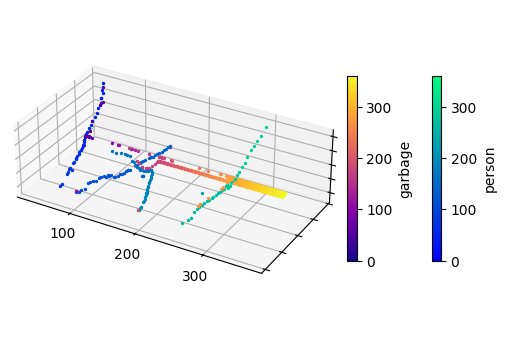

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize

def draw_3d(results):
    norm = Normalize(vmin=0, vmax=len(results))
    colormap_person = cm.winter(norm(range(len(results))))
    colormap_garbage = cm.plasma(norm(range(len(results))))

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect([30,16,9])
    
    for frame, result in enumerate(results):
        boxes = result.boxes
        for box in boxes:
            if box.cls == 0:
                x, y, _, _ = box.xywh.int().tolist()[0]
                ax.scatter(frame, x, y, color=colormap_person[frame], s=2)
            elif box.cls == 80:
                x, y, _, _ = box.xywh.int().tolist()[0]
                ax.scatter(frame, x, y, color=colormap_garbage[frame], s=2)


    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    for line in ax.yaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.zaxis.get_ticklines():
        line.set_visible(False)

    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.winter), ax=ax, label='person', shrink=0.5)
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.plasma), ax=ax, label='garbage', shrink=0.5)
draw_3d(results)